In [1]:
import numpy as np
import pandas as pd
import pyterrier as pt
if not pt.started():
  pt.init()

In [ ]:
def get_webtrack_gov():
#     for k in ["trec-wt-2002", "trec-wt-2003", "trec-wt-2004"]:
    for k in ["trec-wt-2004"]:
        ds = pt.get_dataset(k)
        print(dir(ds))
#         for t in ["np", "td", "hp"]:
        for t in ["all"]:
            topics = ds.get_topics(t)
            indexref=ds.get_index
            qrels = ds.get_qrels(t)
            return (qrels, topics, indexref)

qrels, topics, indexref = get_webtrack_gov()

In [2]:
dataset = pt.datasets.get_dataset("vaswani")
#dataset = pt.datasets.get_dataset("trec-wt-2012")
print(dataset)
indexref = dataset.get_index()
print(type(indexref))
topics = dataset.get_topics()
qrels = dataset.get_qrels()

RemoteDataset for vaswani, with ['corpus', 'topics', 'qrels', 'index']
<class 'jnius.reflect.org.terrier.querying.IndexRef'>


In [3]:
print(type(qrels))
print(len(topics))
print(len(qrels))

<class 'pandas.core.frame.DataFrame'>
93
2083


In [4]:
#this ranker will make the candidate set of documents for each query
BM25 = pt.BatchRetrieve(indexref, controls = {"wmodel": "BM25"})

#these rankers we will use to re-rank the BM25 results
TF_IDF =  pt.BatchRetrieve(indexref, controls = {"wmodel": "TF_IDF"})
PL2 =  pt.BatchRetrieve(indexref, controls = {"wmodel": "PL2"})
DPH = pt.BatchRetrieve(indexref, controls = {"wmodel": "DPH"})
PL2F =  pt.BatchRetrieve(indexref, controls = {"wmodel": "PL2F"})

In [20]:
feature_batch_retriever = pt.FeaturesBatchRetrieve(indexref, controls = {"wmodel": "BM25"}, features=["WMODEL:TF_IDF", "WMODEL:PL2", "WMODEL:DPH", "WMODEL:BM25"]) 

In [21]:
type(feature_batch_retriever)

pyterrier.batchretrieve.FeaturesBatchRetrieve

In [22]:
(BM25 %2).transform("world")

,qid,docid,docno,rank,score,query
0,1,11388,11389,0,11.070585,world
1,1,236,237,1,10.532366,world


In [23]:
(PL2).transform("world")

,qid,docid,docno,rank,score,query
0,1,11388,11389,0,5.709237,world
1,1,236,237,1,5.418427,world
2,1,10678,10679,2,5.072714,world
3,1,11000,11001,3,5.004905,world
4,1,3130,3131,4,4.813460,world
...,...,...,...,...,...,...
66,1,5806,5807,66,2.060231,world
67,1,4923,4924,67,2.034954,world
68,1,4509,4510,68,2.034954,world
69,1,3445,3446,69,1.686487,world


In [24]:
train_topics, valid_topics, test_topics = np.split(topics, [int(.6*len(topics)), int(.8*len(topics))])

In [25]:
from sklearn.ensemble import RandomForestRegressor

ltr_model = feature_batch_retriever >> pt.pipelines.LTR_pipeline(RandomForestRegressor(n_estimators=400))
ltr_model.fit(train_topics, qrels)

In [26]:
results = pt.pipelines.Experiment([TF_IDF, BM25, PL2, ltr_model], test_topics, qrels, ["map", "ndcg"], names=["TF-IDF", "BM25 algorithm", "PL2 Baseline", "LTR Random Forest"])
results

,name,map,ndcg
0,TF-IDF,0.217554,0.550142
1,BM25 algorithm,0.217680,0.551313
2,PL2 Baseline,0.206031,0.537795
3,LTR Random Forest,0.145187,0.489995


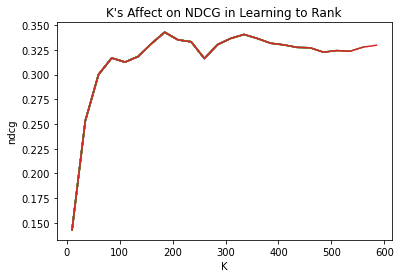

In [27]:
import matplotlib.pyplot as plt  # plotting libraries

def run_experiment(trained_model, mop, start= 10, finish = 600, incrementer = 25, top_k_model = BM25, title="sample title"):
    k_list = []
    moe_list = []
    for k in range(start, finish, incrementer):
        efficient_pipeline = top_k_model % k >> trained_model
        results = pt.pipelines.Experiment([efficient_pipeline], test_topics, qrels, [mop], names=["model"])
        k_list.append(k)
        moe_list.append(results[mop].iloc[0])
        
        plt.plot(k_list, moe_list)
        plt.xlabel("K")
        plt.ylabel(mop)
        file_name = title.replace(" ", "-")
        plt.title(title)
        plt.savefig(file_name)
        
run_experiment(ltr_model, "ndcg", title = "K's Affect on NDCG in Learning to Rank")